In [1]:
#lib 
from IPython import display
from numpy import ndarray 
import numpy as np 
from typing import List,Tuple
from copy import deepcopy

In [2]:
def assert_same_shape(array, array_grad):
    assert array.shape == array_grad.shape, '''
        Two ndarrays should have the same shape;
        instead, first ndarray's shape is {0}
        and second ndarray's shape is {1}.'''.format(tuple(array_grad.shape), tuple(array.shape))
    return None

# Deep Learning From Scratch 

* The Building Blocks of Neural Networks: Operations
The Operation class will represent one of the constituent functions in our neural networks.
We know that at a high level, based on the way we’ve used such functions in
our models, it should have forward and backward methods, each of which receives an
ndarray as an input and outputs an ndarray. Some operations, such as matrix multiplication,
seem to have another special kind of input, also an ndarray: the parameters.
In our Operation class—or perhaps in another class that inherits from it—we should
allow for params as another instance variable.
Another insight is that there seem to be two types of Operations: some, such as the
matrix multiplication, return an ndarray as output that is a different shape than the
ndarray they received as input; by contrast, some Operations, such as the sigmoid
function, simply apply some function to each element of the input ndarray. What,
then, is the “general rule” about the shapes of the ndarrays that get passed between
our operations? Let’s consider the ndarrays passed through our Operations: each
Operation will send outputs forward on the forward pass and will receive an “output
gradient” on the backward pass, which will represent the partial derivative of the loss
with respect to every element of the Operation’s output (computed by the other
Operations that make up the network). Also on the backward pass, each Operation
The Building will send an “input gradient” backward, representing the partial derivative of the loss
with respect to each element of the input.
These facts place a few important restrictions on the workings of our Operations that
will help us ensure we’re computing the gradients correctly:

        • The shape of the output gradient ndarray must match the shape of the output.

        • The shape of the input gradient that the Operation sends backward during the backward pass must match the shape of the Operation’s input.

## Helper classes (Operation and ParamOperation)

In [3]:
class Operation(object):
    '''
    Base class for an "operation" in a neural network.
    '''
    def __init__(self):
        pass

    def forward(self, input_: ndarray):
        '''
        Stores input in the self._input instance variable
        Calls the self._output() function.
        '''
        self.input_ = input_

        self.output = self._output()

        return self.output


    def backward(self, output_grad: ndarray) -> ndarray:
        '''
        Calls the self._input_grad() function.
        Checks that the appropriate shapes match.
        '''
        assert_same_shape(self.output, output_grad)

        self.input_grad = self._input_grad(output_grad)

        assert_same_shape(self.input_, self.input_grad)
        return self.input_grad


    def _output(self) -> ndarray:
        '''
        The _output method must be defined for each Operation
        '''
        raise NotImplementedError()


    def _input_grad(self, output_grad: ndarray) -> ndarray:
        '''
        The _input_grad method must be defined for each Operation
        '''
        raise NotImplementedError()

* We’re defining base classes like this primarily for pedagogical reasons:
it is important to have the mental model that all Operations
you’ll encounter throughout deep learning fit this blueprint of
sending inputs forward and gradients backward, with the shapes of
what they receive on the forward pass matching the shapes of what
they send backward on the backward pass, and vice versa.

In [4]:
class ParamOperation(Operation):
    '''
    An Operation with parameters.
    '''

    def __init__(self, param: ndarray) -> ndarray:
        '''
        The ParamOperation method
        '''
        super().__init__()
        self.param = param

    def backward(self, output_grad: ndarray) -> ndarray:
        '''
        Calls self._input_grad and self._param_grad.
        Checks appropriate shapes.
        '''

        assert_same_shape(self.output, output_grad)

        self.input_grad = self._input_grad(output_grad)
        self.param_grad = self._param_grad(output_grad)

        assert_same_shape(self.input_, self.input_grad)
        assert_same_shape(self.param, self.param_grad)

        return self.input_grad

    def _param_grad(self, output_grad: ndarray) -> ndarray:
        '''
        Every subclass of ParamOperation must implement _param_grad.
        '''
        raise NotImplementedError()

## The Building Blocks of Neural Networks: Layers

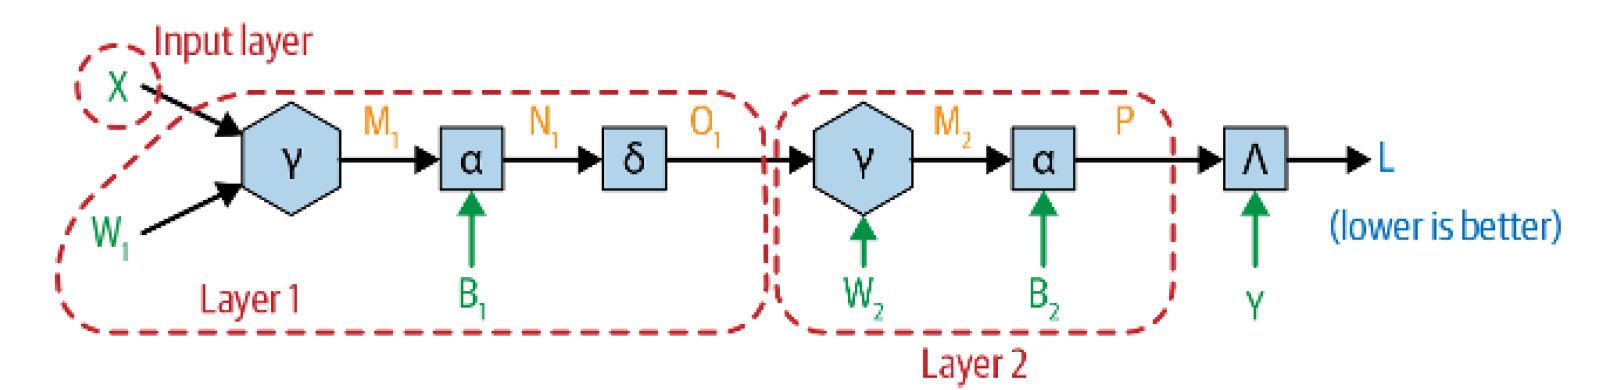

In [5]:
display.Image("./pic1.png")

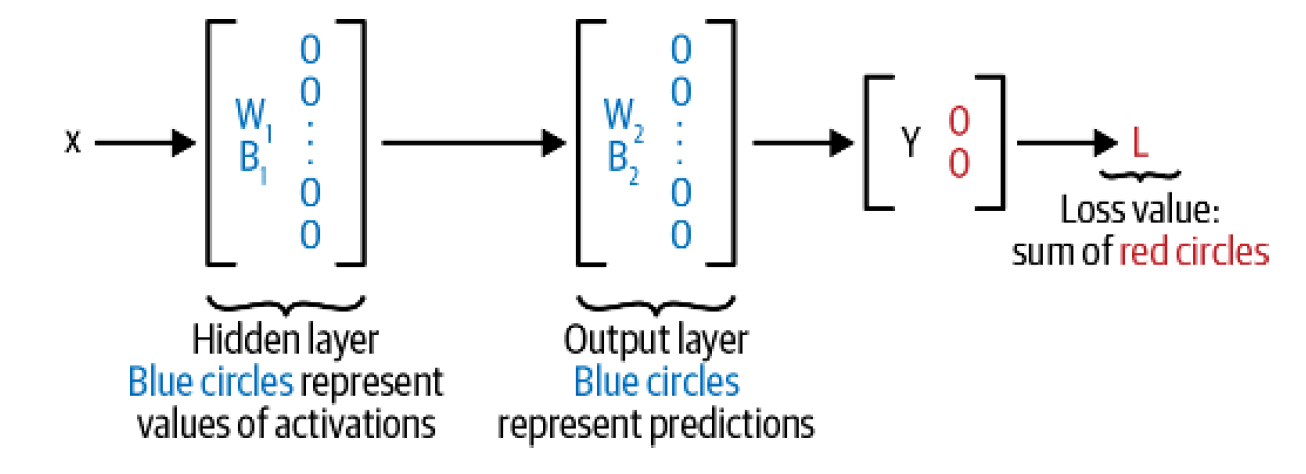

In [6]:
display.Image("./pic2.png")

## Connection to the brain

Finally, let’s make one last connection between what we’ve seen so far and a notion
you’ve likely heard before: each layer can be said to have a certain number of neurons
equal to the dimensionality of the vector that represents each observation in the layer’s
output. The neural network from the prior example can thus be thought of as having
13 neurons in the input layer, then 13 neurons (again) in the hidden layer, and one
neuron in the output layer.


*** Neurons in the brain have the property that they can receive inputs from many other
neurons and will “fire” and send a signal forward only if the signals they receive
cumulatively reach a certain “activation energy.” Neurons in the context of neural networks
have a loosely analogous property: they do indeed send signals forward based
on their inputs, but the inputs are transformed into outputs simply via a nonlinear
function. Thus, this nonlinear function is called the activation function, and the values
that come out of it are called the activations for that layer

## Building Blocks on Building Blocks

What specific Operations do we need to implement for the models in the prior chapter
to work? Based on our experience of implementing that neural network step by
step, we know there are three kinds:
    
    • The matrix multiplication of the input with the matrix of parameters
    • The addition of a bias term
    • The sigmoid activation function

Let’s start with the WeightMultiply Operation:

###  Specific Operations 

In [7]:
class WeightMultiply(ParamOperation):
    '''
        Weight multiplication operation for a neural network.
    '''
    
    def __init__(self, W):
        '''
            Initialize Operation with self.param = W.
        '''
        super().__init__(W)
        
    def _output(self):
        '''
            Compute output.
        '''
        return np.dot(self.input_, self.param)
    
    def _input_grad(self, output_grad):
        '''
            Compute input gradient.
        '''
        return np.dot(output_grad, np.transpose(self.param, (1,0)) )
    
    def _param_grad(self, output_grad):
        '''
            Compute parameter gradient.
        '''
        return np.dot(np.transpose(self.input_, (1,0)), output_grad)

In [8]:
class BiasAdd(ParamOperation):
    '''
        Compute bias addition.
    '''
    
    def __init__(self, B):
        '''
            Initialize Operation with self.param = B
            Check appropriate shape.
        '''
        assert B.shape[0] == 1 
        
        super().__init__(B)
        
    def _output(self):
        '''
            Compute output.
        '''
        return self.input_ + self.param 
    
    def _input_grad(self, output_grad):
        '''
            Compute input gradient.
        '''
        return np.ones_like(self.input_) * output_grad
    
    def _param_grad(self, output_grad):
        '''
            Compute parameter gradient.
        '''
        param_grad = np.ones_like(self.param) * output_grad
        return np.sum(param_grad, axis=0).reshape(1, param_grad.shape[1])

In [9]:
class Sigmoid(Operation):
    '''
        Sigmoid activation function.
    '''
    
    def __init__(self):
        '''Pass'''
        super().__init__()
        
    def _output(self):
        '''
            Compute output.
        '''
        
        return 1.0 / (1.0 + np.exp(-1.0 * self.input_))
    
    def _input_grad(self, output_grad):
        '''
            Compute input gradient. 
        '''
        sigmoid_backward = self.output * (1.0 - self.output)
        input_grad = sigmoid_backward * output_grad
        return input_grad

In [10]:
class Linear(Operation):
    '''
    "Identity" activation function
    '''

    def __init__(self) -> None:
        '''Pass'''        
        super().__init__()

    def _output(self) -> ndarray:
        '''Pass through'''
        return self.input_

    def _input_grad(self, output_grad: ndarray) -> ndarray:
        '''Pass through'''
        return output_grad

Now that we’ve defined these Operations precisely, we can use them as building
blocks to define a Layer.

## The Layer and Dense

In [11]:
class Layer(object):
    '''
    A "layer" of neurons in a neural network.
    '''

    def __init__(self,
                 neurons: int):
        '''
        The number of "neurons" roughly corresponds to the "breadth" of the layer
        '''
        self.neurons = neurons
        self.first = True
        self.params: List[ndarray] = []
        self.param_grads: List[ndarray] = []
        self.operations: List[Operation] = []

    def _setup_layer(self, num_in: int) -> None:
        '''
        The _setup_layer function must be implemented for each layer
        '''
        raise NotImplementedError()

    def forward(self, input_: ndarray) -> ndarray:
        '''
        Passes input forward through a series of operations
        ''' 
        if self.first:
            self._setup_layer(input_)
            self.first = False

        self.input_ = input_

        for operation in self.operations:

            input_ = operation.forward(input_)

        self.output = input_

        return self.output

    def backward(self, output_grad: ndarray) -> ndarray:
        '''
        Passes output_grad backward through a series of operations
        Checks appropriate shapes
        '''

        assert_same_shape(self.output, output_grad)

        for operation in reversed(self.operations):
            output_grad = operation.backward(output_grad)

        input_grad = output_grad
        
        self._param_grads()

        return input_grad

    def _param_grads(self) -> ndarray:
        '''
        Extracts the _param_grads from a layer's operations
        '''

        self.param_grads = []
        for operation in self.operations:
            if issubclass(operation.__class__, ParamOperation):
                self.param_grads.append(operation.param_grad)

    def _params(self) -> ndarray:
        '''
        Extracts the _params from a layer's operations
        '''

        self.params = []
        for operation in self.operations:
            if issubclass(operation.__class__, ParamOperation):
                self.params.append(operation.param)

## The Dense Layer

* We called the Operations we’ve been dealing with WeightMultiply, BiasAdd, and so on. What should we call the layer we’ve been using so far? A LinearNonLinear layer?

* A defining characteristic of this layer is that each output neuron is a function of all of the input neurons

In [12]:
class Dense(Layer):
    '''
    A fully connected layer which inherits from "Layer"
    '''
    def __init__(self,
                 neurons: int,
                 activation: Operation = Sigmoid()):
        '''
        Requires an activation function upon initialization
        '''
        super().__init__(neurons)
        self.activation = activation

    def _setup_layer(self, input_: ndarray) -> None:
        '''
        Defines the operations of a fully connected layer.
        '''
        if self.seed:
            np.random.seed(self.seed)

        self.params = []

        # weights
        self.params.append(np.random.randn(input_.shape[1], self.neurons))

        # bias
        self.params.append(np.random.randn(1, self.neurons))

        self.operations = [WeightMultiply(self.params[0]),
                           BiasAdd(self.params[1]),
                           self.activation]

        return None

* What building blocks should we now add on top of Operation and Layer? 
    * To train our model, we know we’ll need a NeuralNetwork class to wrap around Layers, just as Layers wrapped around Operations. It isn’t obvious what other classes will be needed, 
    * so we’ll just dive in and build NeuralNetwork and figure out the other classes we’ll need as we go.

## The NeuralNetwork Class, and Maybe Others

* How exactly will this learning take place, given the Layer and Operation classes just
defined? Recalling how the model from the last chapter worked, we’ll implement the
following:

    1. The neural network should take X and pass it successively forward through each Layer (which is really a convenient wrapper around feeding it through many Operations), at which point the result will represent the prediction.

    2. Next, prediction should be compared with the value y to calculate the loss and generate the “loss gradient,” which is the partial derivative of the loss with respect to each element in the last layer in the network (namely, the one that generated the prediction).
    
    3. Finally, we’ll send this loss gradient successively backward through each layer, along the way computing the “parameter gradients”—the partial derivative of the loss with respect to each of the parameters—and storing them in the corresponding Operations.

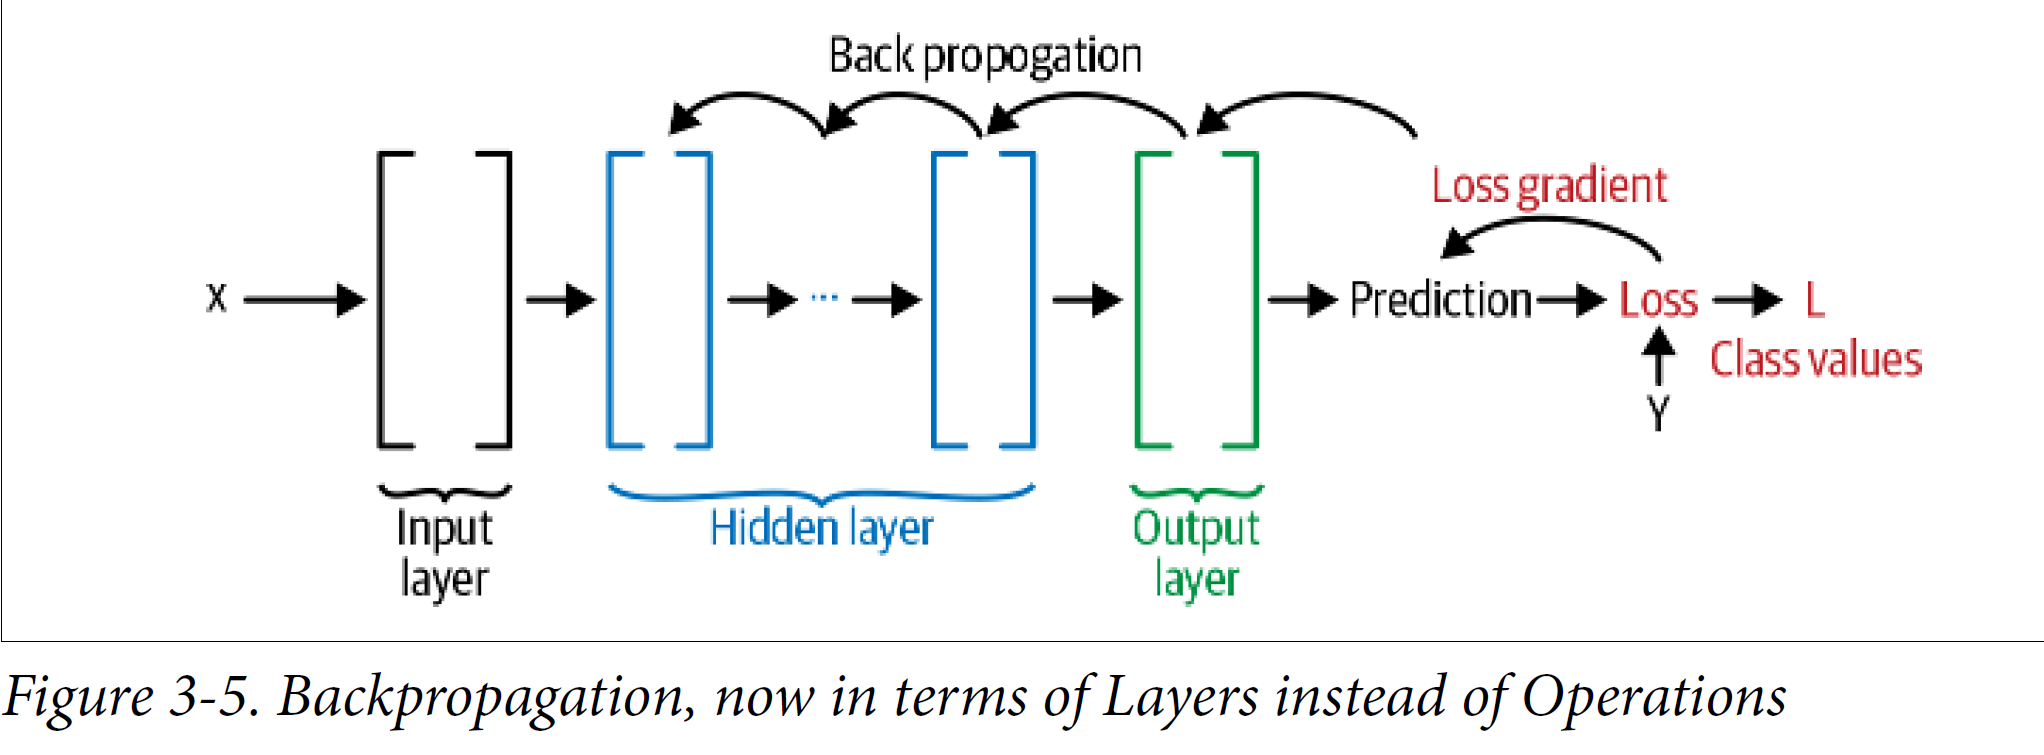

In [13]:
display.Image("./pic3.png")

### Loss Class

* The Loss base class will be similar to Layer—the forward and backward methods will
check that the shapes of the appropriate ndarrays are identical and define two methods,
_output and _input_grad, that any subclass of Loss will have to define

In [14]:
class Loss(object):
    '''
        The "loss" of a neural network.
    '''
    
    def __init__(self):
        '''Pass'''
        pass
    
    def forward(self, prediction: ndarray, target: ndarray) -> float:
        '''
            Computes the actual loss value.
        '''
        
        assert_same_shape(prediction, target)
        
        self.prediction = prediction
        self.target = target 
        
        loss_value = self._output()
        
        return loss_value
    
    def backward(self) -> ndarray:
        '''
            Computes gradient of the loss value with respect to the input to the loss function.
        '''
        
        self.input_grad = self._input_grad()
        
        assert_same_shape(self.prediction, self.input_grad)
        
        return self.input_grad
    
    def _output(self) -> float:
        '''
            Every subclass of "Loss" must implement the _output function.
        '''
        raise NotImplementedError()
        
    def _input_grad(self) -> ndarray:
        '''
            Every subclass of "Loss" must implement the _input_grad function.
        '''
        raise NotImplementedError()
        

In [15]:
class MeanSquaredError(Loss):
    
    def __init__(self):
        '''Pass'''
        super().__init__()
        
    def _output(self) -> float:
        '''
            Computes the per-observation squared error loss.
        '''
        
        loss = np.sum(np.power(self.prediction - self.target, 2)) / self.prediction.shape[0]
        
        return loss
    
    def _input_grad(self) -> ndarray:
        '''
            Computes the loss gradient with respect to the input for MSE loss.
        '''
        return 2.0 * (self.prediction - self.target) / self.prediction.shape[0]

    

# Deep Learning from Scratch

Before we dive in and start coding, let’s describe precisely what such a class would be and how it would interact with the Operation, Layer, and Loss classes we just defined:


1. A NeuralNetwork will have a list of Layers as an attribute. The Layers would be as defined previously, with forward and backward methods. These methods take in ndarray objects and return ndarray objects.


2. Each Layer will have a list of Operations saved in the operations attribute of the layer during the _setup_layer function.

3. These Operations, just like the Layer itself, have forward and backward methods that take in ndarray objects as arguments and return ndarray objects as outputs.

4. In each operation, the shape of the output_grad received in the backward method must be the same as the shape of the output attribute of the Layer. The same is true for the shapes of the input_grad passed backward during the back ward method and the input_ attribute.

5. Some operations have parameters (stored in the param attribute); these operations inherit from the ParamOperation class. The same constraints on input and output shapes apply to Layers and their forward and backward methods as well —they take in ndarray objects and output ndarray objects, and the shapes of the input and output attributes and their corresponding gradients must match.

6. A NeuralNetwork will also have a Loss. This class will take the output of the last operation from the NeuralNetwork and the target, check that their shapes are the same, and calculate both a loss value (a number) and an ndarray loss_grad that will be fed into the output layer, starting backpropagation.

## NeuralNetwork: Code

In [16]:
class NeuralNetwork(object):
    '''
    The class for a neural network.
    '''
    def __init__(self, 
                 layers: List[Layer],
                 loss: Loss,
                 seed: int = 1) -> None:
        '''
        Neural networks need layers, and a loss.
        '''
        self.layers = layers
        self.loss = loss
        self.seed = seed
        if seed:
            for layer in self.layers:
                setattr(layer, "seed", self.seed)        

    def forward(self, x_batch: ndarray) -> ndarray:
        '''
        Passes data forward through a series of layers.
        '''
        x_out = x_batch
        for layer in self.layers:
            x_out = layer.forward(x_out)

        return x_out

    def backward(self, loss_grad: ndarray) -> None:
        '''
        Passes data backward through a series of layers.
        '''

        grad = loss_grad
        for layer in reversed(self.layers):
            grad = layer.backward(grad)

        return None

    def train_batch(self,
                    x_batch: ndarray,
                    y_batch: ndarray) -> float:
        '''
        Passes data forward through the layers.
        Computes the loss.
        Passes data backward through the layers.
        '''
        
        predictions = self.forward(x_batch)

        loss = self.loss.forward(predictions, y_batch)

        self.backward(self.loss.backward())

        return loss
    
    def params(self):
        '''
        Gets the parameters for the network.
        '''
        for layer in self.layers:
            yield from layer.params

    def param_grads(self):
        '''
        Gets the gradient of the loss with respect to the parameters for the network.
        '''
        for layer in self.layers:
            yield from layer.param_grads

With this NeuralNetwork class, we can implement the models from the prior chapter
in a more modular, flexible way and define other models to represent complex nonlinear
relationships between input and output. For example, here’s how to easily
instantiate the two models we covered in the last chapter—the linear regression and
the neural network:3
    linear_regression = NeuralNetwork(
                                        layers=[Dense(neurons = 1)],
                                        loss = MeanSquaredError(),
                                        learning_rate = 0.01
                                      )
        neural_network = NeuralNetwork(
                                        layers=[Dense(neurons=13,
                                        activation=Sigmoid()),
                                        Dense(neurons=1,
                                        activation=Linear())],
                                        loss = MeanSquaredError(),
                                        learning_rate = 0.01
                                        )

## Optimizer and SGD

 each Layer contains a simple rule for
updating the weights based on the parameters and their gradients. As we’ll touch on
in the next chapter, there are many other update rules we can use, such as ones
involving the history of gradient updates rather than just the gradient updates from
the specific batch that was fed in at that iteration. Creating a separate Optimizer class
will give us the flexibility to swap in one update rule for another, something that we’ll
explore in more detail in the next chapter.
Description and

In [17]:
class Optimizer(object):
    '''
        Base class for a neural network optimizer.
    '''
    
    def __init__(self, lr: float(0.01)):
        '''
            Every optimizer must have an initial learning rate.
        '''
        self.lr = lr 
        
    def step(self) -> None:
        '''
            Every optimizer implement the "step" function.
        '''
        pass
    

In [18]:
class SGD(Optimizer): # Stochastic gradient descent
    '''
        Stochastic gradient descent optimizer.
    '''
    
    def __init__(self, lr: float=0.01) -> None:
        '''Pass'''
        super().__init__(lr)
        
    def step(self):
        '''
            For each parameter, adjust in the appropriate direction, 
            with the magnitude of the adjustment based on the learning rate
        '''
        for (param, param_grad) in zip(self.net.params(),
                                       self.net.param_grads()):
            param -= self.lr * param_grad
            
            

## Trainer

In addition to training the model as described previously, the Trainer class also links
together the NeuralNetwork with the Optimizer, ensuring the latter trains the former
properly.

In [19]:
from copy import deepcopy
from typing import Tuple

class Trainer(object):
    '''
    Trains a neural network
    '''
    def __init__(self,
                 net: NeuralNetwork,
                 optim: Optimizer) -> None:
        '''
        Requires a neural network and an optimizer in order for training to occur. 
        Assign the neural network as an instance variable to the optimizer.
        '''
        self.net = net
        self.optim = optim
        self.best_loss = 1e9
        setattr(self.optim, 'net', self.net)
        
    def generate_batches(self,
                         X: ndarray,
                         y: ndarray,
                         size: int = 32) -> Tuple[ndarray]:
        '''
        Generates batches for training 
        '''
        assert X.shape[0] == y.shape[0], \
        '''
        features and target must have the same number of rows, instead
        features has {0} and target has {1}
        '''.format(X.shape[0], y.shape[0])

        N = X.shape[0]

        for ii in range(0, N, size):
            X_batch, y_batch = X[ii:ii+size], y[ii:ii+size]

            yield X_batch, y_batch

            
    def fit(self, X_train: ndarray, y_train: ndarray,
            X_test: ndarray, y_test: ndarray,
            epochs: int=100,
            eval_every: int=10,
            batch_size: int=32,
            seed: int = 1,
            restart: bool = True)-> None:
        '''
        Fits the neural network on the training data for a certain number of epochs.
        Every "eval_every" epochs, it evaluated the neural network on the testing data.
        '''

        np.random.seed(seed)
        if restart:
            for layer in self.net.layers:
                layer.first = True

            self.best_loss = 1e9

        for e in range(epochs):

            if (e+1) % eval_every == 0:
                
                # for early stopping
                last_model = deepcopy(self.net)

            X_train, y_train = permute_data(X_train, y_train)

            batch_generator = self.generate_batches(X_train, y_train,
                                                    batch_size)

            for ii, (X_batch, y_batch) in enumerate(batch_generator):

                self.net.train_batch(X_batch, y_batch)

                self.optim.step()

            if (e+1) % eval_every == 0:

                test_preds = self.net.forward(X_test)
                loss = self.net.loss.forward(test_preds, y_test)

                if loss < self.best_loss:
                    print(f"Validation loss after {e+1} epochs is {loss:.3f}")
                    self.best_loss = loss
                else:
                    print(f"""Loss increased after epoch {e+1}, final loss was {self.best_loss:.3f}, using the model from epoch {e+1-eval_every}""")
                    self.net = last_model
                    # ensure self.optim is still updating self.net
                    setattr(self.optim, 'net', self.net)
                    break

## Evaluation metrics

In [20]:
def mae(y_true: ndarray, y_pred: ndarray):
    '''
    Compute mean absolute error for a neural network.
    '''    
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true: ndarray, y_pred: ndarray):
    '''
    Compute root mean squared error for a neural network.
    '''
    return np.sqrt(np.mean(np.power(y_true - y_pred, 2)))

def eval_regression_model(model,
                          X_test: ndarray,
                          y_test: ndarray):
    '''
    Compute mae and rmse for a neural network.
    '''
    preds = model.forward(X_test)
    preds = preds.reshape(-1, 1)
    print("Mean absolute error: {:.2f}".format(mae(preds, y_test)))
    print()
    print("Root mean squared error {:.2f}".format(rmse(preds, y_test)))

In [21]:
lr = NeuralNetwork(
    layers=[Dense(neurons=1,
                   activation=Linear())],
    loss=MeanSquaredError(),
    seed=20190501
)

nn = NeuralNetwork(
    layers=[Dense(neurons=13,
                   activation=Sigmoid()),
            Dense(neurons=1,
                   activation=Linear())],
    loss=MeanSquaredError(),
    seed=20190501
)

dl = NeuralNetwork(
    layers=[Dense(neurons=13,
                   activation=Sigmoid()),
            Dense(neurons=13,
                   activation=Sigmoid()),
            Dense(neurons=1,
                   activation=Linear())],
    loss=MeanSquaredError(),
    seed=20190501
)

# Read in the data, train-test split etc.

In [22]:
from sklearn.datasets import load_boston

boston = load_boston()
data = boston.data
target = boston.target
features = boston.feature_names

In [23]:
# Scaling the data
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
data = s.fit_transform(data)

In [24]:
def to_2d_np(a: ndarray, 
          type: str="col") -> ndarray:
    '''
    Turns a 1D Tensor into 2D
    '''

    assert a.ndim == 1, \
    "Input tensors must be 1 dimensional"
    
    if type == "col":        
        return a.reshape(-1, 1)
    elif type == "row":
        return a.reshape(1, -1)

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=80718)

# make target 2d array
y_train, y_test = to_2d_np(y_train), to_2d_np(y_test)

## Train the three models

In [26]:
# helper function

def permute_data(X, y):
    perm = np.random.permutation(X.shape[0])
    return X[perm], y[perm]

In [27]:
trainer = Trainer(lr, SGD(lr=0.01))

trainer.fit(X_train, y_train, X_test, y_test,
       epochs = 50,
       eval_every = 10,
       seed=20190501);
print()
eval_regression_model(lr, X_test, y_test)

Validation loss after 10 epochs is 30.293
Validation loss after 20 epochs is 28.469
Validation loss after 30 epochs is 26.293
Validation loss after 40 epochs is 25.541
Validation loss after 50 epochs is 25.087

Mean absolute error: 3.52

Root mean squared error 5.01


In [28]:
trainer = Trainer(dl, SGD(lr=0.01))

trainer.fit(X_train, y_train, X_test, y_test,
       epochs = 50,
       eval_every = 10,
       seed=20190501);
print()
eval_regression_model(dl, X_test, y_test)

Validation loss after 10 epochs is 44.143
Validation loss after 20 epochs is 25.278
Validation loss after 30 epochs is 22.339
Validation loss after 40 epochs is 16.500
Validation loss after 50 epochs is 14.655

Mean absolute error: 2.45

Root mean squared error 3.83
